# A Look at Wildlife Diseases in Utah

This notebook analyses wildlife disease data from Utah DWR captures in the 2021-2022 fall/winter capture season. Please see [the github repo](https://github.com/epistemetrica/utah_dwr_python) for more info. 

## Project Description

Each observation in our dataset includes big game animal species, capture date and location, sex, pregnancy status, and the results of various disease-related lab tests.

### Key tasks:
1. Prepare the data for analysis 
2. Explore and visualize the dataset
3. Analyze the data to understand:
    - the prevelance of key diseases among wildlife in Utah
    - whether there is a relationship between disease positivity and pregnancy rates
    - whether this data allows us to accurately predict disease states for new captures




In [1]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
from scipy import stats
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

#settings
%matplotlib inline 
plt.style.use('seaborn-v0_8-deep')

## Data Processing

Lab results and DWR capture data were loaded into a SQLite db via the wildlife_ETL.py pipeline. 

In [2]:
#connect to db
engine = create_engine('sqlite:///data/wildlife.db')

#load dfs
bison_df = pd.read_sql_table(con=engine, table_name='bison_table')
deer_df = pd.read_sql_table(con=engine, table_name='deer_table')
elk_df = pd.read_sql_table(con=engine, table_name='elk_table')
moose_df = pd.read_sql_table(con=engine, table_name='moose_table')
pronghorn_df = pd.read_sql_table(con=engine, table_name='pronghorn_table')
sheep_goat_df = pd.read_sql_table(con=engine, table_name='sheep_goat_table')

### Missing Values

Generally speaking, missing values in this dataset indicate that information was not gathered for that animal; i.e., NaN values under ehdv_result mean that sample was not submitted for ehdv testing. For this reason, I am careful to preserve NaN entries and to avoid replacing NaN with 0, as that would indicate a negative test result for animals never tested.  

NaN values are only dropped on an ad_hoc basis for certain tasks, with one major exception: rows with empty sample_id values are dropped en masse, as these entries have no test results associted with them and test results are what we're here for. 

### Let's take a look at the data:

In [3]:
display(bison_df.head())
bison_df.info()

,sample_id,archive_id,species,sex,capture_date,capture_unit,bvd_type1_result,bvd_type2_result,ehdv_result,preg_val,preg_result,bluetongue_result
0,BCB1101,BIS21-018,Bison,Female,2022-02-27,Book Cliffs,Negative,Negative,Positive,0.091,Not pregnant,Detected
1,BCB1102,BIS21-019,Bison,Female,2022-02-26,Book Cliffs,Negative,Negative,Negative,0.749,Pregnant,Not detected
2,BCB1103,BIS21-020,Bison,Female,2022-02-27,Book Cliffs,Negative,Negative,Negative,0.091,Not pregnant,Not detected
3,BCB1104,BIS21-021,Bison,Female,2022-02-26,Book Cliffs,Negative,Negative,Negative,0.718,Pregnant,Not detected
4,BCB1105,BIS21-022,Bison,Male,2022-02-26,Book Cliffs,Negative,Negative,Negative,0.089,Not pregnant,Not detected


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   sample_id          35 non-null     object        
 1   archive_id         15 non-null     object        
 2   species            33 non-null     object        
 3   sex                33 non-null     object        
 4   capture_date       33 non-null     datetime64[ns]
 5   capture_unit       33 non-null     object        
 6   bvd_type1_result   34 non-null     object        
 7   bvd_type2_result   34 non-null     object        
 8   ehdv_result        34 non-null     object        
 9   preg_val           34 non-null     float64       
 10  preg_result        34 non-null     object        
 11  bluetongue_result  34 non-null     object        
dtypes: datetime64[ns](1), float64(1), object(10)
memory usage: 3.4+ KB


In [4]:
display(deer_df.head())
deer_df.info()

,sample_id,collar_id,species,sex,capture_date,capture_unit,staging_area,weight,age,capture_lat,capture_long,body_condition,lactation,comments,adenovirus_result,adenovirus_val,ehdv_result,bluetongue_result
0,None,50757.0,Mule Deer,Female,2021-12-04,Manti,Dragon,57.0,2.5,39.223900,-111.19577,5.00,0.25,None,None,None,None,None
1,None,47499.0,Mule Deer,Female,2021-12-06,Manti,Muddy Creek,59.0,5.5,38.986850,-111.34039,5.25,0.25,None,None,None,None,None
2,None,50596.0,Mule Deer,Female,2021-12-02,South Slope,Diamond Rim,68.0,8.5,40.585583,-109.26791,4.50,0.75,Banamine and Vitamin E \nJared 342\nOld collar...,None,None,None,None
3,None,44716.0,Mule Deer,Female,2021-11-23,South Slope,Moon Lake,68.0,3.5,40.541190,-110.47582,4.50,0.50,"died - hit a fence, broken neck, pulled her jaw",None,None,None,None
4,None,40437.0,Mule Deer,Female,2021-11-29,San Juan,Baullies,55.0,4.5,NaN,NaN,2.75,0.50,deer broke leg and was put down - dead,None,None,None,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 609 entries, 0 to 608
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   sample_id          375 non-null    object        
 1   collar_id          604 non-null    float64       
 2   species            604 non-null    object        
 3   sex                604 non-null    object        
 4   capture_date       599 non-null    datetime64[ns]
 5   capture_unit       604 non-null    object        
 6   staging_area       561 non-null    object        
 7   weight             574 non-null    float64       
 8   age                602 non-null    float64       
 9   capture_lat        556 non-null    float64       
 10  capture_long       553 non-null    float64       
 11  body_condition     385 non-null    float64       
 12  lactation          345 non-null    float64       
 13  comments           340 non-null    object        
 14  adenovirus

In [5]:
display(elk_df.head())
elk_df.info()

,sample_id,archive_id,collar_id,species,sex,capture_date,capture_unit,staging_area,age,comments,ehdv_type1_result,ehdv_type1_val,ehdv_type2_result,ehdv_type2_val,ehdv_type6_result,ehdv_type6_val,bvd_result,preg_val,preg_result,bluetongue_result
0,BCE1132,EL21-137,51628.0,Elk,Female,2022-03-07,Book Cliffs,Bryson Canyon,23.5,None,Negative,<20,Positve,>1280,Negative,<20,Negative,0.660,Pregnant,Detected
1,BCE1134,EL21-138,46687.0,Elk,Female,2022-03-07,Book Cliffs,Bryson Canyon,19.5,None,Negative,<20,Negative,<20,Negative,<20,Negative,0.649,Pregnant,Detected
2,BCE1135,EL21-139,46752.0,Elk,Female,2022-03-07,Book Cliffs,Bryson Canyon,10.5,None,Negative,<20,Positive,40,Negative,<20,Negative,0.087,Open,Not detected
3,BCE1136,EL21-140,51622.0,Elk,Female,2022-03-07,Book Cliffs,Bryson Canyon,13.5,None,Negative,<20,Negative,<20,Negative,<20,Negative,0.621,Pregnant,Not detected
4,BCE1138,EL21-141,46700.0,Elk,Female,2022-03-07,Book Cliffs,Bryson Canyon,22.5,None,Negative,<20,Negative,<20,Negative,<20,Negative,0.612,Pregnant,Not detected


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   sample_id          148 non-null    object        
 1   archive_id         45 non-null     object        
 2   collar_id          146 non-null    float64       
 3   species            146 non-null    object        
 4   sex                146 non-null    object        
 5   capture_date       146 non-null    datetime64[ns]
 6   capture_unit       146 non-null    object        
 7   staging_area       136 non-null    object        
 8   age                145 non-null    float64       
 9   comments           9 non-null      object        
 10  ehdv_type1_result  145 non-null    object        
 11  ehdv_type1_val     145 non-null    object        
 12  ehdv_type2_result  145 non-null    object        
 13  ehdv_type2_val     145 non-null    object        
 14  ehdv_type6

In [6]:
display(moose_df.head())
moose_df.info()

,sample_id,collar_id,species,sex,capture_date,capture_unit,staging_area,preg_val,preg_result,bluetongue_result
0,PAR1111,50888,Moose,Female,2021-12-19,Parley's Summit,Little Dell Reservoir,0.105,Open,Not detected
1,PAR1112,50891,Moose,Female,2021-12-19,Parley's Summit,Little Dell Reservoir,1.165,Pregnant,Not detected
2,PAR1113,50892,Moose,Female,2021-12-19,Parley's Summit,Little Dell Reservoir,1.180,Pregnant,Not detected
3,PAR1114,50890,Moose,Female,2021-12-19,Parley's Summit,Little Dell Reservoir,1.202,Pregnant,Not detected
4,PAR1115,50889,Moose,Female,2021-12-19,Parley's Summit,Little Dell Reservoir,1.177,Pregnant,Not detected


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   sample_id          5 non-null      object        
 1   collar_id          5 non-null      int64         
 2   species            5 non-null      object        
 3   sex                5 non-null      object        
 4   capture_date       5 non-null      datetime64[ns]
 5   capture_unit       5 non-null      object        
 6   staging_area       5 non-null      object        
 7   preg_val           5 non-null      float64       
 8   preg_result        5 non-null      object        
 9   bluetongue_result  5 non-null      object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 532.0+ bytes


In [7]:
display(pronghorn_df.head())
pronghorn_df.info()

,sample_id,archive_id,collar_id,species,sex,capture_date,capture_unit,staging_area,bluetongue_result,eimeria_OPG,strongyles_EPG,nematodirus_EPG
0,BCP1101,PH21-001,50770.0,Pronghorn,Female,2021-12-01,Book Cliffs,Danish Flat,Detected,NaN,NaN,NaN
1,BCP1102,PH21-002,50776.0,Pronghorn,Female,2021-12-01,Book Cliffs,Danish Flat,None,NaN,NaN,NaN
2,BCP1103,PH21-003,50769.0,Pronghorn,Female,2021-12-01,Book Cliffs,Danish Flat,Detected,NaN,NaN,NaN
3,BCP1104,PH21-015,50768.0,Pronghorn,Male,2021-12-01,Book Cliffs,Danish Flat,Detected,NaN,NaN,NaN
4,BCP1105,PH21-004,50774.0,Pronghorn,Female,2021-12-01,Book Cliffs,Danish Flat,Detected,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   sample_id          113 non-null    object        
 1   archive_id         15 non-null     object        
 2   collar_id          83 non-null     float64       
 3   species            108 non-null    object        
 4   sex                83 non-null     object        
 5   capture_date       108 non-null    datetime64[ns]
 6   capture_unit       108 non-null    object        
 7   staging_area       50 non-null     object        
 8   bluetongue_result  109 non-null    object        
 9   eimeria_OPG        22 non-null     float64       
 10  strongyles_EPG     11 non-null     float64       
 11  nematodirus_EPG    4 non-null      float64       
dtypes: datetime64[ns](1), float64(4), object(7)
memory usage: 10.7+ KB


In [8]:
display(sheep_goat_df.head())
sheep_goat_df.info()

,sample_id,collar_id,species,sex,capture_date,capture_unit,staging_area,comments,movi_elisa_val,movi_elisa_result,movi_pcr_result,lentivirus_val,lentivirus_result,ehdv_val,ehdv_result,bluetongue_result,leukotoxin_lktA_result,tonsular_culture_result,tonsular_culture_isolate
0,SRS1101,50750.0,Bighorn Sheep,Female,2021-12-03,North San Rafael,Swinging Bridge,2 tonsillar swabs and 2 nasal swabs (SRS1101),80.903,Detected,Not detected,1.366,Negative,103.562,Negative,Negative,Not detected,No Pasteurella isolated.,None
1,SRS1102,50744.0,Bighorn Sheep,Female,2021-12-04,North San Rafael,Swinging Bridge,2 tonsillar swabs and 2 nasal swabs (SRS1102),61.281,Detected,Not detected,0.936,Negative,39.983,Indeterminate,Positive,Not detected,No Pasteurella isolated.,None
2,SRS1103,50749.0,Bighorn Sheep,Female,2021-12-03,North San Rafael,Swinging Bridge,"Short blood, veins flat, worried about heat. 2...",90.380,Detected,Detected,3.908,Negative,65.718,Negative,Positive,Not detected,No Pasteurella isolated.,None
3,SRS1104,50758.0,Bighorn Sheep,Female,2021-12-04,North San Rafael,Swinging Bridge,2 tonsillar swabs and 2 nasal swabs (SRS1104),72.088,Detected,None,2.541,Negative,61.098,Negative,Positive,None,None,None
4,SRS1105,50752.0,Bighorn Sheep,Female,2021-12-03,North San Rafael,Swinging Bridge,"Recapture. Old collar: 75535, 148.307. 2 tonsi...",74.081,Detected,Not detected,5.923,Negative,78.161,Negative,Negative,Not detected,No Pasteurella isolated.,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   sample_id                 71 non-null     object        
 1   collar_id                 57 non-null     float64       
 2   species                   62 non-null     object        
 3   sex                       58 non-null     object        
 4   capture_date              60 non-null     datetime64[ns]
 5   capture_unit              60 non-null     object        
 6   staging_area              10 non-null     object        
 7   comments                  16 non-null     object        
 8   movi_elisa_val            69 non-null     float64       
 9   movi_elisa_result         69 non-null     object        
 10  movi_pcr_result           57 non-null     object        
 11  lentivirus_val            69 non-null     float64       
 12  lentivirus_result       

In [9]:
#concat dfs
species_dfs = [bison_df, deer_df, elk_df, pronghorn_df, sheep_goat_df]
df = pd.concat(species_dfs)

display(df.head())
df.info()

,sample_id,archive_id,species,sex,capture_date,capture_unit,bvd_type1_result,bvd_type2_result,ehdv_result,preg_val,...,nematodirus_EPG,movi_elisa_val,movi_elisa_result,movi_pcr_result,lentivirus_val,lentivirus_result,ehdv_val,leukotoxin_lktA_result,tonsular_culture_result,tonsular_culture_isolate
0,BCB1101,BIS21-018,Bison,Female,2022-02-27,Book Cliffs,Negative,Negative,Positive,0.091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BCB1102,BIS21-019,Bison,Female,2022-02-26,Book Cliffs,Negative,Negative,Negative,0.749,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BCB1103,BIS21-020,Bison,Female,2022-02-27,Book Cliffs,Negative,Negative,Negative,0.091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BCB1104,BIS21-021,Bison,Female,2022-02-26,Book Cliffs,Negative,Negative,Negative,0.718,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BCB1105,BIS21-022,Bison,Male,2022-02-26,Book Cliffs,Negative,Negative,Negative,0.089,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Index: 976 entries, 0 to 70
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   sample_id                 742 non-null    object        
 1   archive_id                75 non-null     object        
 2   species                   953 non-null    object        
 3   sex                       924 non-null    object        
 4   capture_date              946 non-null    datetime64[ns]
 5   capture_unit              951 non-null    object        
 6   bvd_type1_result          34 non-null     object        
 7   bvd_type2_result          34 non-null     object        
 8   ehdv_result               439 non-null    object        
 9   preg_val                  176 non-null    float64       
 10  preg_result               176 non-null    object        
 11  bluetongue_result         691 non-null    object        
 12  collar_id                 89

### Pause and reflect

I just want to take a moment here and remember what we're looking at. From late October 2021 to early June 2022, Utah DWR staff captured and released more than *nine hundred* big game animals. Each capture typically involves 5-10 staff, including biologists, veterinarians, and other highly trained technicians, and many animals are tranquilized via dart gun from a helicopter. 

The cost associated with this dataset is breathtaking, and it is only a small part of the efforts our state and tribal agencies expend to care for and manage *our* wildlife in the United States. For more information on the work that these agencies do, visit the [AFWA's website](https://www.fishwildlife.org/) and the [Utah DWR's website](https://wildlife.utah.gov/).

Ok, back to the data science ;). 

### Drop unnecessary columns and rows

Many of the columns in the database are not relevant to this project. For example, if the animal is pregnant, the exact value of the pregnancy test does not matter here. And as noted in the *definitions.md* file, columns like 'archive_id' are not useful for this project. I also drop the fecal sample results, as they only apply to a handful of animals. 

There are also a handful of entries that do not have any associated lab results, as noted by the DWR Office's comments in the original spreadsheets. These rows are dropped. 

In [10]:
#drop columns not relevant to this project
df = df.drop(columns=['archive_id', 'preg_val', 'collar_id', 'staging_area', 'ehdv_type1_val', 'ehdv_type2_val', 'ehdv_type6_val', 
                      'movi_elisa_val', 'lentivirus_val', 'ehdv_val', 'tonsular_culture_isolate', 'eimeria_OPG', 'strongyles_EPG', 
                      'nematodirus_EPG', 'adenovirus_val'])

#drop known duplicates and animals with missing samples.
comments_to_drop = ['*Double number, one sample', '*No record', '*missing sample']
df = df.drop(df[df.comments.isin(comments_to_drop)].index)

#drop rows with no sample_id -- these are included in the tables used by the DWR vet office, but not useful here.
df = df.dropna(subset='sample_id')

#drop comments column
del df['comments']

As a means of inspecting the data, let's look at the various values contained within each column:

In [11]:
for col in df.columns:
    print('The {} column has the following value counts: \n {} \n'.format(col, df[col].value_counts()))

The sample_id column has the following value counts: 
 sample_id
BCB1101     1
CCE1112     1
CCE1114     1
CCE1115     1
CCE1116     1
           ..
NT1125      1
NT1126      1
NT1127      1
NT1128      1
BH21-010    1
Name: count, Length: 727, dtype: int64 

The species column has the following value counts: 
 species
Mule Deer        370
Elk              141
Pronghorn        104
Mt Goat           47
Bison             32
Bighorn Sheep     13
Name: count, dtype: int64 

The sex column has the following value counts: 
 sex
Female    596
Male       82
Name: count, dtype: int64 

The capture_date column has the following value counts: 
 capture_date
2021-12-13    35
2021-12-20    31
2022-02-06    31
2021-12-11    30
2021-12-10    30
2021-12-18    30
2021-12-01    29
2021-12-05    26
2021-12-12    26
2022-02-05    26
2021-11-29    25
2022-02-24    25
2022-02-28    25
2021-11-23    24
2021-11-30    24
2021-12-16    23
2021-12-14    20
2021-12-02    19
2021-11-21    19
2021-11-22    18
2021-

The columns that report bovine viral diarrhea and lentivirus are entirely negative, meaning those diseases are absent from the database. We can drop those columns entirely. 

In [12]:
#drop variables with all-negative results
df = df.drop(columns=['bvd_type1_result', 'bvd_type2_result', 'bvd_result', 'lentivirus_result'])

### Data Types

Before we get to the exploratory analysis section, let's clean up the data types. To ease analysis later on, variables are encoded as binary values wherever possible (e.g., 'sex' with values of 'Female' and 'Male' becomes 'female' with values of 1 or 0). 

In [13]:
def results_to_binary(df, column_name, positives_list):
    ''' Converts string columns to binary numeric 1/0 values based on a specified list, preserving NaN values.
    inputs: 
        df - a pandas dataframe
        column - a single column name
        positives_list - a list of strings corresponding to positive results of a test; will be set to one

    output:
        df.column_name - the converted column
    '''
    df[column_name] = df[column_name].apply(lambda row: 1 if row in positives_list else np.NaN if pd.isna(row) else 0).astype('Int64')
    return df[column_name]

#convert sex and drop previous column
df['female'] = results_to_binary(df, 'sex', ['Female'])
del df['sex']

#convert other test results
cols_to_convert = ['preg_result', 'bluetongue_result', 'movi_elisa_result', 'movi_pcr_result', 'leukotoxin_lktA_result', 'ehdv_result',
                   'ehdv_type1_result', 'ehdv_type2_result', 'ehdv_type6_result', 'tonsular_culture_result', 'adenovirus_result']
positives_list = ['Pregnant', 'Detected', 'Positive', 'POSITIVE', 'Weak Positive', 'Positve', 'Moderate', 'Many', 'Few']
for col in cols_to_convert:
    df[col] = results_to_binary(df, col, positives_list)

#merge ehdv cols - the specific type of edhv virus is not relevant here
df['ehdv_result'] = df[['ehdv_result', 'ehdv_type1_result', 'ehdv_type2_result', 'ehdv_type6_result']].sum(axis=1)
df.ehdv_result = df.ehdv_result.apply(lambda row: 0 if row == 0 else np.NaN if pd.isna(row) else 1)
df.drop(columns=['ehdv_type1_result', 'ehdv_type2_result', 'ehdv_type6_result'])

#reorder cols because I'm picky
df = df[['sample_id', 'species', 'capture_date', 'capture_unit', 'capture_lat', 'capture_long', 'female', 'weight', 'age', 
         'body_condition', 'lactation', 'preg_result', 'bluetongue_result', 'adenovirus_result', 'ehdv_result', 
         'movi_elisa_result', 'movi_pcr_result', 'leukotoxin_lktA_result', 'tonsular_culture_result']]

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 727 entries, 0 to 70
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   sample_id                727 non-null    object        
 1   species                  707 non-null    object        
 2   capture_date             705 non-null    datetime64[ns]
 3   capture_unit             705 non-null    object        
 4   capture_lat              353 non-null    float64       
 5   capture_long             350 non-null    float64       
 6   female                   678 non-null    Int64         
 7   weight                   367 non-null    float64       
 8   age                      510 non-null    float64       
 9   body_condition           369 non-null    float64       
 10  lactation                329 non-null    float64       
 11  preg_result              170 non-null    Int64         
 12  bluetongue_result        676 non-null    I

## Exploratory Analysis

Now that our data is even tidy-er, we can start looking around in a more meaningful way. 

### Pregnancy 

Pregnancy tests were performed for elk and bison. 

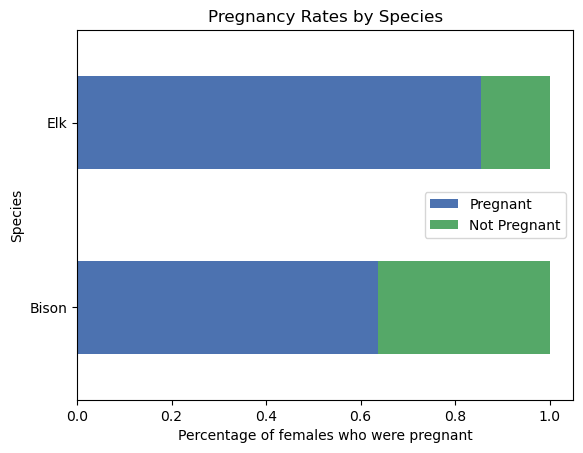

In [15]:
#create df showing pregnancy result for tested female animals ## NOTE all bison were reported by the lab as "Pregnant" or "Not Pregnant", so I need to filter for only females.
preggers_df = df[df.preg_result.notna() & df.female == 1]

#create df of pregnancy rates
preg_plot_df = preggers_df[['species', 'preg_result']].groupby('species', as_index=False).mean()
preg_plot_df['Not Pregnant'] = 1 - preg_plot_df.preg_result
preg_plot_df.columns = ['Species', 'Pregnant', 'Not Pregnant']

#plot stacked bar chart
p = preg_plot_df.plot(x='Species', 
                  kind='barh', 
                  stacked=True, 
                  title='Pregnancy Rates by Species'
                  );
p.set_xlabel('Percentage of females who were pregnant');
p.set_ylabel('Species');

In [16]:
preg_plot_df

,Species,Pregnant,Not Pregnant
0,Bison,0.636364,0.363636
1,Elk,0.854015,0.145985


I don't know about you, but I find this pretty fascinating. A whopping *85%* of captured female elk were pregnant at time of capture (Note: it is not possible to tell if a cow elk is pregnant before capture, so this rate is roughly proportional to the general population). As a point of reference, the March of Dimes Foundation [reported](https://www.marchofdimes.org/peristats/data?reg=99&top=2&stop=2&lev=1&slev=1&obj=1) the fertility rate among women of reproductive age in the US to be around *5.6%* in 2020. It's interesting to ponder the relative evolutionaary strategies ungulates like elk and bison have taken compared to our own species. 

### Disease Prevalence 

tasks:
- make multi-chart image of interesting diseases
    - m.ovi for sheep and goats
- Bayesian estimation of population prevalence?
- Heat map of a disease for deer



In [17]:
df[['species', 'female', 'weight', 'age', 'body_condition',
       'lactation', 'preg_result', 'bluetongue_result', 'adenovirus_result',
       'ehdv_result', 'movi_elisa_result', 'movi_pcr_result', 'leukotoxin_lktA_result',
       'tonsular_culture_result']].groupby('species').mean()

,female,weight,age,body_condition,lactation,preg_result,bluetongue_result,adenovirus_result,ehdv_result,movi_elisa_result,movi_pcr_result,leukotoxin_lktA_result,tonsular_culture_result
species,,,,,,,,,,,,,
Bighorn Sheep,0.818182,NaN,NaN,NaN,NaN,<NA>,0.615385,<NA>,0.230769,0.923077,0.090909,0.0,0.0
Bison,0.6875,NaN,NaN,NaN,NaN,0.451613,0.387097,<NA>,0.406250,<NA>,<NA>,<NA>,<NA>
Elk,0.985816,NaN,9.364286,NaN,NaN,0.854015,0.253623,<NA>,0.269504,<NA>,<NA>,<NA>,<NA>
Mt Goat,0.666667,NaN,NaN,NaN,NaN,<NA>,0.0,<NA>,0.000000,0.222222,0.045455,0.090909,0.090909
Mule Deer,0.889189,63.224796,5.462162,3.321491,0.423252,<NA>,0.201807,0.936556,0.205405,<NA>,<NA>,<NA>,<NA>
Pronghorn,0.848101,NaN,NaN,NaN,NaN,<NA>,0.79,<NA>,0.000000,<NA>,<NA>,<NA>,<NA>


The above chart gives us a handy reference for the sample averages for each metric. For the disease-related tests, these numbers give us the prevalence of each disease for each species. Let's take a more visual look at some key diseases:

#### Hemorraghic Disease

[Bluetongue virus (BTV)](https://www.aphis.usda.gov/aphis/ourfocus/animalhealth/animal-disease-information/cattle-disease-information/bluetongue-disease-info) affects ruminants worldwide, and can have widely varied effects. In fact, a standard veterinary manual [states](https://www.merckvetmanual.com/generalized-conditions/bluetongue/bluetongue-in-ruminants) that BTV has "a mortality rate of 2-90%." One can only imagine the smirk on the author's face while typing that. BTV can be devastaing to some domestic animals ([particulary sheep](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6385761/)) so it's important to understand the prevalence in wildlife that may interact with them. We will return to the issue of wild/domestic disease transfer in a bit. 

[Epizootic hemorrhagic disease virus (EHDV)](https://www.pirbright.ac.uk/viruses/ehdv), like Bluetongue, is a common pathogen among wildlife that can also affect domestic animals. In fact, the two pathogens are closely related and together constitute the causal agents of [Hemorrhagic Disease](https://cwhl.vet.cornell.edu/disease/hemorrhagic-disease-deer), so we will look at them together:

In [34]:
#create btv prevalence df
btv_df = df.dropna(subset='bluetongue_result')
btv_df = btv_df[['sample_id', 'species', 'female', 'preg_result', 'bluetongue_result']]
btv_prev_df = btv_df.drop(columns='sample_id').groupby('species', as_index=False).mean()

#create EHDV prevalence df
ehdv_df = df.dropna(subset='ehdv_result')
ehdv_df = ehdv_df[['sample_id', 'species', 'female', 'preg_result', 'ehdv_result']]
ehdv_prev_df = ehdv_df.drop(columns='sample_id').groupby('species', as_index=False).mean()

#combined prevalence df
hd_df = btv_df.merge(ehdv_df[['sample_id', 'ehdv_result']], how='inner', on='sample_id')
hd_df['hd_result'] = hd_df.ehdv_result + hd_df.bluetongue_result
hd_prev_df = hd_df.drop(columns='sample_id').groupby('species', as_index=False).mean()


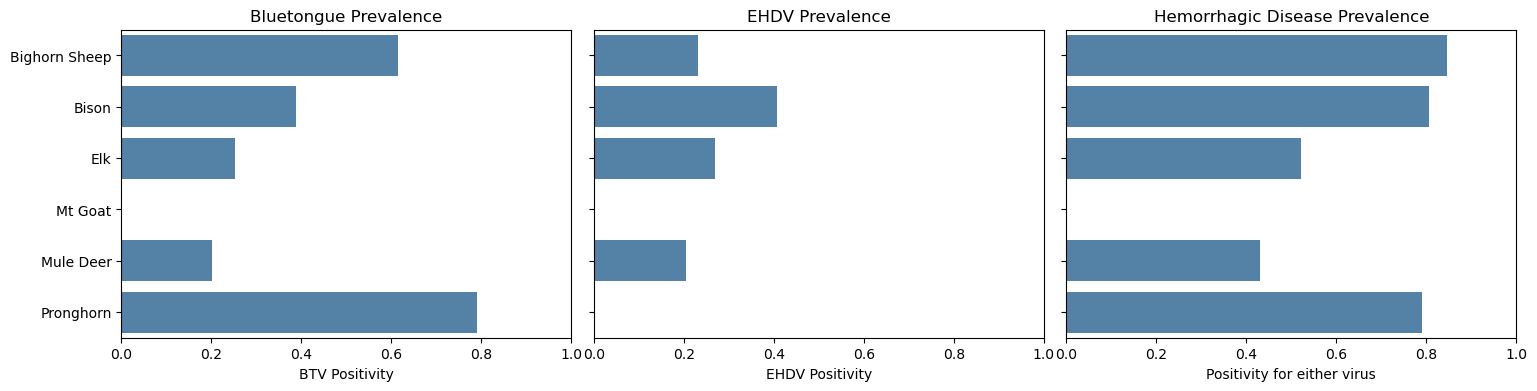

In [56]:
#barplot BTV and EHDV by species
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
plt.subplots_adjust(wspace=0.05)

p1 = sns.barplot(data=btv_prev_df, x='bluetongue_result', y='species', color='steelblue', ax=ax[0]);
p1.set(ylabel='', xlabel='BTV Positivity', title= 'Bluetongue Prevalence');
p1.set_xlim(0,1);

p2 = sns.barplot(data=ehdv_prev_df, x='ehdv_result', y='species', color='steelblue', ax=ax[1])
p2.set(ylabel='', xlabel='EHDV Positivity', title='EHDV Prevalence');
p2.set_xlim(0,1);
p2.set_yticklabels([None]*6);

p3 = sns.barplot(data=hd_prev_df, x='hd_result', y='species', color='steelblue', ax=ax[2]);
p3.set(ylabel='', xlabel='Positivity for either virus', title='Hemorrhagic Disease Prevalence');
p3.set_xlim(0,1);
p3.set_yticklabels([None]*6);

In [ ]:
#build df to plot preg status by BTV status
btv_preg_df = btv_df[btv_df.female == 1].dropna(subset=['preg_result'])
btv_preg_df = btv_preg_df.drop(columns='species')
plot_df = btv_preg_df.groupby('bluetongue_result', as_index=False).mean()
plot_df

In [ ]:
p = sns.barplot(data=plot_df, x='preg_result', y='bluetongue_result', orient='h', color='steelblue');
p.set(ylabel='', xlabel='Pregnancy Rate', title= 'Pregnancy Rates by BTV Status');
p.set_yticklabels(['BTV Negative', 'BTV Positive']);
p.set_xlim(0,1);

A potential issue with bluetongue mentioned by the Utah wildlife vet is an impact on pregnancy rates. As we can see above, BTV-positive females have a slightly *higher* pregnancy rate, potentially indicating a positive relationship between pregnancy and the presense of the virus. This may, of course, be a statistical fluke due to the fact that 82% of female animals tested for pregnancy were in fact pregnant. To be thorough, let's run a Welch's t-test:

In [ ]:
preg_btv_ar = btv_preg_df.preg_result[btv_preg_df.bluetongue_result == 1].dropna().astype(int)
preg_nobtv_ar = btv_preg_df.preg_result[btv_preg_df.bluetongue_result == 0].dropna().astype(int)

#t-test
stats.ttest_ind(preg_btv_ar, preg_nobtv_ar, equal_var=False)

**Question for Udacity Reviewer:** Why did I need to recast preg_btv_ar and preg_nobtv_ar arrays back to int dtype? All columns used to generate the arrays were ints, so why did python cast the resulting arrays as object dtypes?  Thanks!

A p-value of 0.312 means we cannot reject the null hypothesis that pregnancy rates are the same for BTV-positive and BTV-negative females. 

#### Pregnancy and EHDV

let's take a look at Epizootic Hemorrhagic Disease Virus (EHDV) and see if a relationship to pregnancy is indicated. 

In [ ]:
#build df to plot preg status by ehdv
preg_ehdv_df = df[df.female == 1].dropna(subset=['preg_result'])
preg_ehdv_df = preg_ehdv_df.drop(columns=['sample_id', 'species', 'capture_date', 'capture_unit', 'capture_lat',
       'capture_long', 'weight', 'age', 'body_condition',
       'lactation'])
plot_df = preg_ehdv_df.groupby('ehdv_result', as_index=False).mean()

plot_df

In [ ]:
p = sns.barplot(data=plot_df, x='preg_result', y='ehdv_result', orient='h', color='steelblue');
p.set(ylabel='', xlabel='Pregnancy Rate', title= 'Pregnancy Rates by EHDV Status');
p.set_yticklabels(['EHDV Negative', 'EHDV Positive']);
p.set_xlim(0,1);

In [ ]:
preg_ehdv_ar = preg_ehdv_df.preg_result[preg_ehdv_df.ehdv_result == 1].dropna().astype(int)
preg_noehdv_ar = preg_ehdv_df.preg_result[preg_ehdv_df.ehdv_result == 0].dropna().astype(int)

stats.ttest_ind(preg_ehdv_ar, preg_noehdv_ar, equal_var=False)

Again, we cannot reject the null -- there is no indication in this dataset of a relationship between pregnancy and pathogen positivity. 


#### Mycoplasma ovipneumoniae

In the Western United States, few ranchers, hunters, or wildlife lovers are unfamiliar with the infamous "[*M. ovi*](https://www.nps.gov/articles/bhs-pneumonia.htm)". One of, if not *the*, primary cause of pneumonia outbreaks that have [wiped out entire herds of wild sheep](https://wdfw.wa.gov/species-habitats/diseases/pneumonia#:~:text=Pneumonia%20outbreaks%20contributed%20to%20the,time%20to%20adapt%20to%20it.), this pathogen is of very high concern for agriculture and wildlife management agencies across the region. 

In this dataset, 44 of 47 mountain goats and 11 of 13 bighorn sheep were tested for *M. ovi*. These animals were tested both for antibodies (ELISA tests, indicating that the animal has been exposed to the virus at some point in the past) as well as the virus itself (PCR tests, indicating the animal is currently infected and shedding the bacteria). 

Let's take a look:


In [ ]:
#construct m ovi df
movi_df = df[df.movi_elisa_result.notna()]
movi_df = movi_df[['sample_id', 'species', 'capture_unit', 'movi_elisa_result', 'movi_pcr_result']]

#show positivity rates by species and management unit
movi_df.drop(columns='sample_id').groupby(['species', 'capture_unit']).mean()

*Mycoplasma ovipneumonia* Test Results by Species and Management Unit

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th></th>
      <th>movi_elisa</th>
      <th>movi_pcr</th>
    </tr>
    <tr>
      <th>Species</th>
      <th>Capture Unit</th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th rowspan="3" valign="top">Bighorn Sheep</th>
      <th>LH Rock</th>
      <td>1.000</td>
      <td>0.000</td>
    </tr>
    <tr>
      <th>North San Rafael</th>
      <td>1.000</td>
      <td>0.111</td>
    </tr>
    <tr>
      <th>Zion</th>
      <td>0.000</td>
      <td>0.000</td>
    </tr>
    <tr>
      <th rowspan="3" valign="top">Mt Goat</th>
      <th>La Sal</th>
      <td>0.000</td>
      <td>0.000</td>
    </tr>
    <tr>
      <th>Uintah</th>
      <td>0.370</td>
      <td>0.074</td>
    </tr>
    <tr>
      <th>Willard</th>
      <td>0.00</td>
      <td>0.00</td>
    </tr>
  </tbody>
</table>
</div>

The chart above indicates that sheep sampled from the North San Rafael and LH Rock units have universal exposure to *M. ovi*. Only two sheep were captured in the LH Rock unit, and only a single animal was captured in the Zion unit. A little more than 11% of the San Rafael sheep were currently infected and shedding the bacteria when sampled. 

The disease is substantially less prevalent in mountain goats, with only 37% of the Uintah herd having been exposed prior to being captured, and 7.4% infected at time of capture. The 11 mountain goats sampled from the La Sal unit tested negative across the board. 

## ML Modeling

Tasks:
1. Define ML Pipeline using Logistic Regression
2. Estimate Bluetongue prevalence for entire dataset
3. Estimate Bluetongue for deer using all available metrics
4. Evaluate Results

In [ ]:
#make df
bluetongue_df = df[['sample_id', 'species', 'sex', 'capture_date', 'capture_unit', 'bluetongue_result']].set_index('sample_id')

#drop date
bluetongue_df = bluetongue_df.drop(columns='capture_date')

#drop missing values
bluetongue_df = bluetongue_df.dropna()

In [ ]:
bluetongue_df = pd.get_dummies(bluetongue_df, columns=['species', 'sex', 'capture_unit'], drop_first=True)

In [ ]:
#split into X,y
X, y = bluetongue_df.drop(columns=['bluetongue_result']), bluetongue_df.bluetongue_result

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y)

#instantiate
model = LogisticRegression()

#fit
model.fit(X_train, y_train)

#predict
y_pred = model.predict(X_test)


In [ ]:
print(classification_report(y_test, y_pred))